# Daily and weekly pathway patterns

## Aim

Show key pathway statistics broken down by:
* Arrival time of day (as per 3 hour intervals)
* Arrival day of week

Replicates SAMueL-1 analyses:
* [Daily patterns](https://samuel-book.github.io/samuel-1/descriptive_stats/02a_daily_patterns.html)
* [Weekly patterns](https://samuel-book.github.io/samuel-1/descriptive_stats/02b_weekly_patterns.html)

## Set up

In [1]:
# Import packages and functions
import collections
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from math import ceil

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data = pd.read_csv(os.path.join(paths.data_path,
                                paths.data_filename))
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Reformatting and function for analysis

(1) Add extra columns for analysis

In [4]:
# Group by whether aged 80 or older
data_full['age_80_plus'] = np.where(data_full['age'] >= 80, 1, 0)

# Group by whether known onset to arrival time is 4 hours or less
data_full['arrive_4h_known'] = np.where(
    (data_full['onset_to_arrival_time'] <= 240) &
    (data_full['onset_known'] == 1), 1, 0)

# Group by whether scanned within 4 hours
data['arrival_to_scan_4h'] = np.where(
    data['arrival_to_scan_time'] <= 240, 1, 0)

# Add arrival to thrombolysis and onset to thrombolysis
data['arrival_to_thrombolysis'] = (
    data['arrival_to_scan_time'] + data['scan_to_thrombolysis_time'])
data['onset_to_thrombolysis'] = (
    data['onset_to_arrival_time'] + data['arrival_to_thrombolysis'])

# Create dataset of just those scanned within 4 hours
data_scan4h = data[data['arrival_to_scan_time'] <= 240]

(2) Define columns of interest

In [5]:
# Define columns of interest and appropriate labels
# (all) and (4h) is used to indicate which dataset to use
# (%) indicates that result should be multiplied by 100
pathway_col = {
    'Arrivals\n(%) (all)': 'arrivals',
    'Thrombolysis\n(%) (all)': 'thrombolysis',
    'Onset known\n(%) (all)': 'onset_known',
    'Aged 80+\n(%) (all)': 'age_80_plus',
    'Mean prior disability\n(mRS) (all)': 'prior_disability',
    'Mean stroke severity\n(NIHSS) (all)': 'stroke_severity',
    'Arrive within 4h\nknown onset (%) (all)': 'arrive_4h_known',
    'Mean prior disability\n(mRS) (arrive 4h)': 'prior_disability',
    'Mean stroke severity\n(NIHSS) (arrive 4h)': 'stroke_severity',
    'Mean onset to arrival\n(min) (arrive 4h)': 'onset_to_arrival_time',
    'Scanned within 4h\narrival (%) (arrive 4h)': 'arrival_to_scan_4h',
    'Mean arrival to scan\n(min) (scan 4h)': 'arrival_to_scan_time',
    'Thrombolysis (%) (scan 4h)': 'thrombolysis',
    'Mean scan to needle\n(min) (scan 4h)': 'scan_to_thrombolysis_time',
    'Mean arrival to needle\n(min) (scan 4h)': 'arrival_to_thrombolysis',
    'Mean onset to needle\n(min) (scan 4h)': 'onset_to_thrombolysis'
}

(3) Function to create plot

In [6]:
def plot_pathway(group):
    '''
    Plot key pathway metrics by specified group (i.e. time of day
    or day of week)
    '''
    # Create subplots, with number of rows from number of variables
    columns = 4
    rows = ceil(len(pathway_col)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(12, 15))

    # Convert keys and values into arrays
    keys = [k for k in pathway_col.keys()]
    values = [v for v in pathway_col.values()]

    # Create plots
    x = 0
    for r in range(rows):
        for c in range(columns):
            # Stops loop (so will leave empty plots)
            if len(pathway_col) == x:
                break
            else:
                # Extract relevant column and label from dictionary
                label = keys[x]
                col = values[x]

                # Reset res (so doesn't plot in case of dataset error)
                res = 0

                if col == 'arrivals':
                    # Count number of rows
                    res = (data_full.groupby(group).size() /
                           len(data_full.index))
                else:
                    # Find mean, grouped by arrival time window
                    if '(all)' in label:
                        res = (data_full
                               .groupby(group)[col]
                               .mean())
                    elif '(arrive 4h)' in label:
                        res = (data
                               .groupby(group)[col]
                               .mean())
                    elif '(scan 4h)' in label:
                        res = (data_scan4h
                               .groupby(group)[col]
                               .mean())
                    else:
                        print('Error - dataset not one of the options')

                # If its marked as percentage, multiply by 100
                if '%' in label:
                    res = res*100

                # If you've grouped by weekday, change to correct order
                if group == 'weekday':
                    res = res.reindex([
                        'Monday', 'Tuesday', 'Wednesday', 'Thursday',
                        'Friday', 'Saturday', 'Sunday'])

                # Plot those results
                res.plot(marker='.', ax=ax[r, c])

                # Set x ticks depending on if numeric (in 'biufc')
                if data[group].dtype.kind in 'biufc':
                    ax[r, c].set_xticks(res.index)
                else:
                    ax[r, c].set_xticks(
                        ticks=range(0, len(res.index)),
                        labels=res.index, rotation=90)

                # Label axis
                ax[r, c].set_xlabel('Time of day')
                ax[r, c].set_ylabel(label)
                ax[r, c].set_title(label)

                # Increment counter
                x += 1

    # Display plot
    plt.tight_layout()
    plt.show()

## Plot by time of day

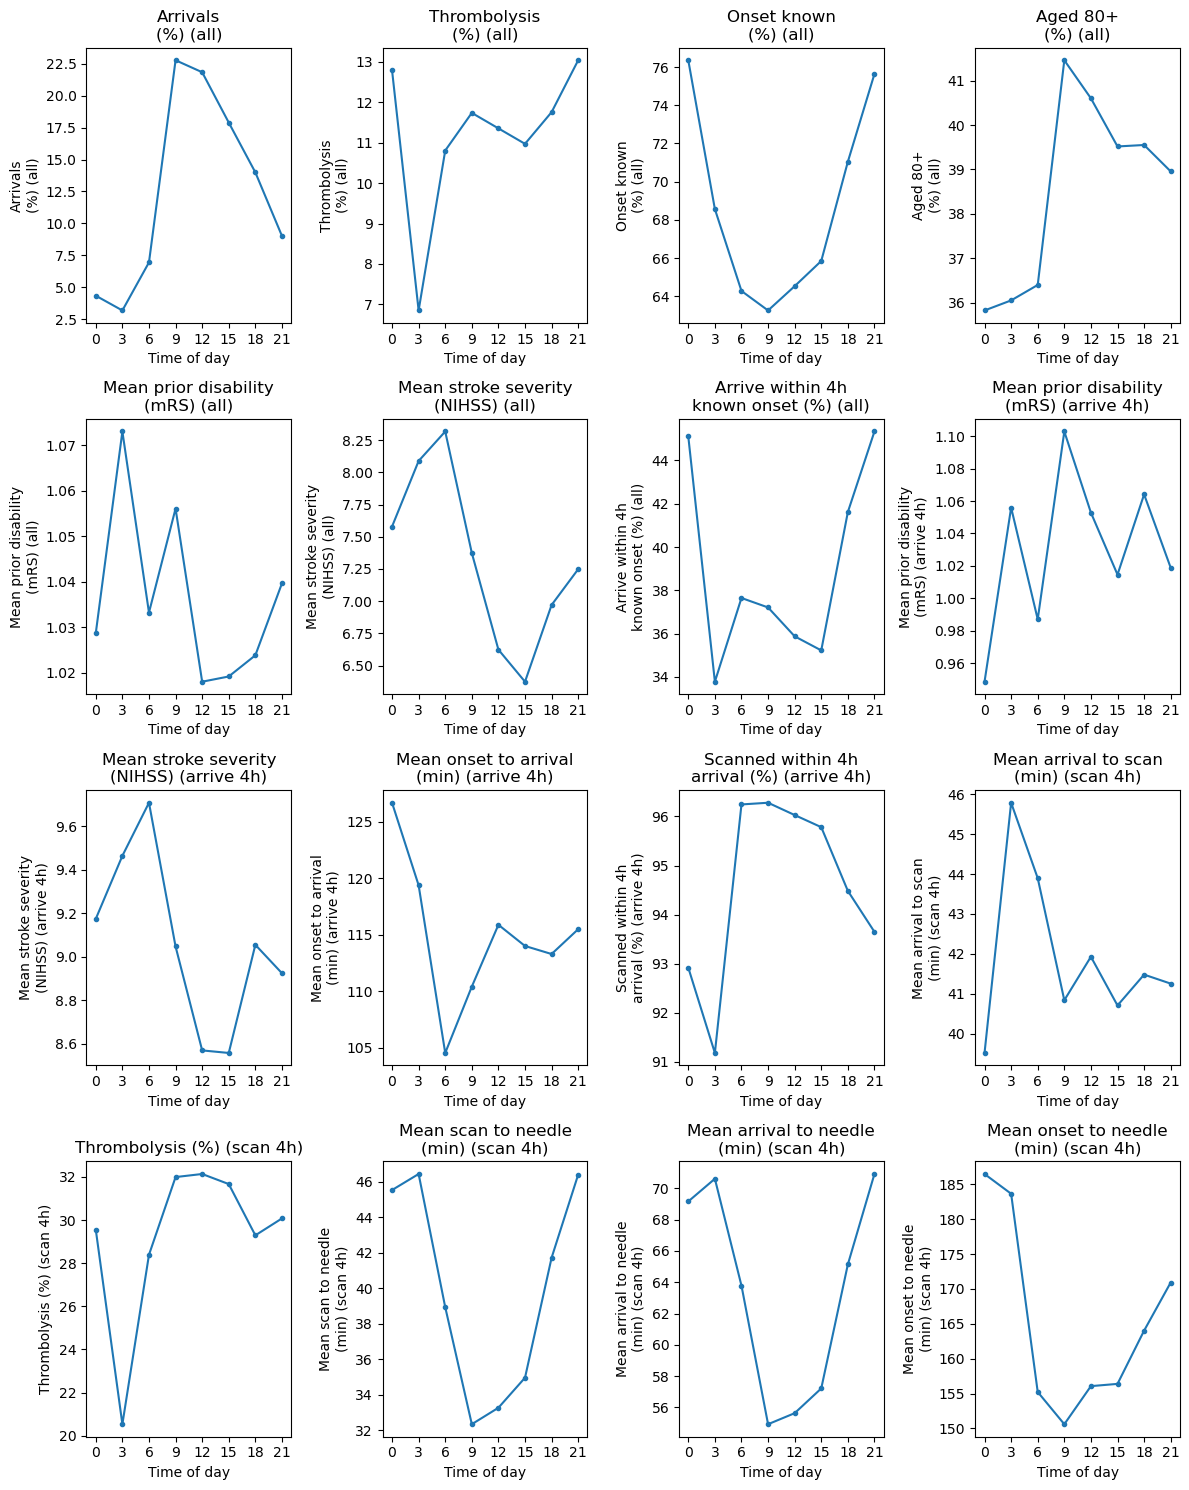

In [7]:
plot_pathway('arrival_time_3_hour_period')

Observations - same as in SAMueL-1:
* Arrivals peak between 9am and 3pm, and then drop steadily to a low between 3am and 6pm.
* Thrombolysis use is significantly lower in the 3am to 6am epoch, but only 3% of admissions occur in this period.
* Arrival-to-scan time is higher 3am to 9am, but reasonably stable for the rest oif the day.
* Scan-to-needle is approximately 10 minutes slower at night (9pm to 9am) than during the day (9am to 9pm).
* The lowest proportion of arrivals with known stroke onset occurs during the day (6am to 6pm).

## Plot by day of week

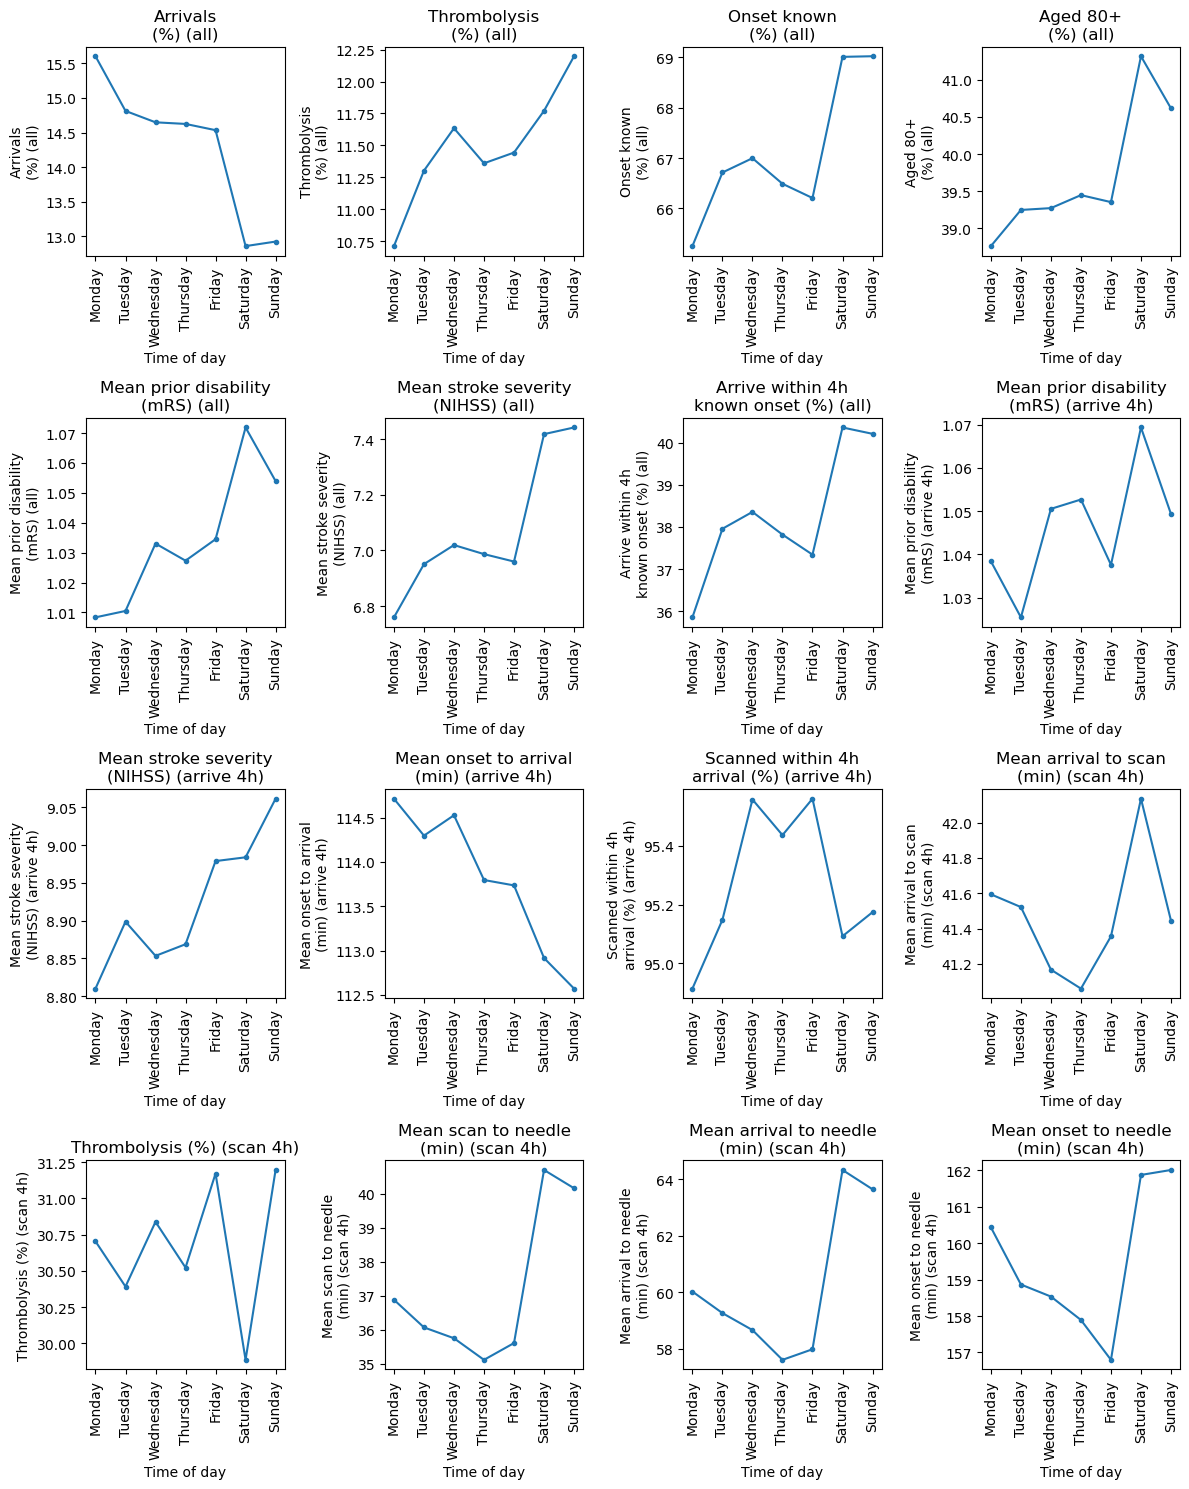

In [8]:
plot_pathway('weekday')

Observations - same as in SAMueL-1:
* Variation in thrombolysis use across week is apx. 1.5% with weekends having slightly higher thrombolysis than weekdays
* Generally, patterns by weekday are weak when considered at national average level

## Thrombolysis use by team and day of week

In [9]:
# Group by stroke team and weekday and find proportion thrombolysed
weekday_ivt_team = (data_full
                    .groupby(['stroke_team', 'weekday'])['thrombolysis']
                    .mean()
                    .reset_index(name='ivt_rate')
                    .pivot(index='stroke_team',
                           columns='weekday',
                           values='ivt_rate'))

# Reorder days
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekend = ['Saturday', 'Sunday']
weekday_ivt_team = weekday_ivt_team[weekdays + weekend]

# Find average thrombolysis rate on weekday v.s. weekend
weekday_ivt_team['mean_weekday'] = weekday_ivt_team[weekdays].mean(axis=1)
weekday_ivt_team['mean_weekend'] = weekday_ivt_team[weekend].mean(axis=1)

# Find difference between weekend and weekday
weekday_ivt_team['difference'] = (weekday_ivt_team['mean_weekend'] -
                                  weekday_ivt_team['mean_weekday'])
# View results
(weekday_ivt_team[['mean_weekday', 'mean_weekend', 'difference']]
 .sort_values(by='difference')*100)

weekday,mean_weekday,mean_weekend,difference
stroke_team,,,
Peterborough City Hospital,12.741335,8.796911,-3.944424
Invicta Ward Kent and Canterbury Hospital,17.433134,13.594470,-3.838664
Royal Blackburn Hospital,9.867582,6.350806,-3.516776
Watford General Hospital,18.172611,14.940429,-3.232183
St Richards Hospital,13.370780,10.664735,-2.706045
...,...,...,...
Blackpool Victoria Hospital,8.303439,11.968205,3.664766
Russells Hall Hospital,10.693423,14.745308,4.051885
Royal London Hospital HASU,19.848795,24.031993,4.183198


Observations: Individual hospitals may show similarities and differences in diurnal patterns to the national average. In the table above, can see some hospitals show a marked reduction in the use of thrombolysis at weekends.